# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
pd.set_option("max_rows",500)

import seaborn as sns

import matplotlib.pyplot as plt

import math

import datetime

# Использую данный десериализатор потому что у него нет проблем с одинарными кавычками
# pip install demjson
from demjson import decode

In [2]:
#Переименуем колонки
original = pd.read_csv('main_task.csv')
new_column_names = {}
for column in original.columns:
    new_column_name = column.lower()
    new_column_name = new_column_name.replace(' ','_')
    new_column_names[column] = new_column_name.strip()
new_column_names['Number of Reviews'] = 'reviews_number'
original.rename(new_column_names,axis=1,inplace=True)
original.head(5)


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
# Описание датафрейма

# Restaurant_id — идентификационный номер ресторана / сети ресторанов;
# City — город, в котором находится ресторан;
# Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
# Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
# Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
# Price Range — диапазон цен в ресторане;
# Number of Reviews — количество отзывов о ресторане;
# Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
# URL_TA — URL страницы ресторана на TripAdvosor;
# ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [4]:
# Ваш код по очистке данных и генерации новых признаков

In [5]:
#Удаляем дубликаты в стобце id_ta
preparation1 = original.drop_duplicates(subset=['id_ta'])

In [6]:
cuisine_styles = preparation1[['id_ta','cuisine_style']]
cuisine_styles['cuisine_style'] = cuisine_styles['cuisine_style'].apply(lambda x: decode(x) if not pd.isna(x) else [])
cuisine_styles = cuisine_styles.set_index(['id_ta'])
cuisine_styles = cuisine_styles.explode('cuisine_style')
cuisine_styles.reset_index(inplace=True)
cuisine_styles.head(10)
preparation1.drop('cuisine_style',axis=1,inplace=True)

F:\projects\skillfactory_rds\envs\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\projects\skillfactory_rds\envs\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
reviews	= pd.DataFrame({'id_ta':preparation1['id_ta'], 'review':preparation1['reviews']})
reviews = reviews.set_index('id_ta')
reviews['review'] = reviews['review'].apply(lambda x:decode(x.replace('nan','"nan"')) if not pd.isna(x) else [])
reviews['review'] = reviews['review'].apply(lambda x:list(zip(*x)))
reviews = reviews.explode('review')
reviews['text'] = [(x[0] if type(x) != float else math.nan) for x in reviews['review']]
reviews['date'] = [(x[1] if type(x) != float else math.nan) for x in reviews['review']]
reviews['date'] = reviews['date'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y').date() if  type(x) is str else x)
reviews.drop('review',inplace=True,axis=1)
reviews.reset_index(inplace=True)
reviews.head(10)
preparation1.drop('reviews',axis=1,inplace=True)

In [8]:
#2.1 Какие столбцы НЕ содержат пропущенных (None) значений?
preparation1.isna().sum()

restaurant_id         0
city                  0
ranking               0
rating                0
price_range       13879
reviews_number     2543
url_ta                0
id_ta                 0
dtype: int64

In [9]:
cuisine_styles.isna().sum()

id_ta               0
cuisine_style    9279
dtype: int64

In [10]:
reviews.isna().sum()

id_ta       0
text     6465
date     6465
dtype: int64

In [11]:
original.isna().sum()

restaurant_id         0
city                  0
cuisine_style      9283
ranking               0
rating                0
price_range       13886
reviews_number     2543
reviews               0
url_ta                0
id_ta                 0
dtype: int64

In [12]:
#2.2 В каких столбцах данные хранятся в числовом формате?
numeric_columns = ['ranking','rating','reviews_number']
print(numeric_columns)

['ranking', 'rating', 'reviews_number']


In [13]:
#4.1.1 Сколько вариантов непустых значений встречается в столбце Price Range? (3)
#4.1.2 Как в датафрейме обозначается самый низкий уровень цен? ($)
#4.1.3 Как в датафрейме обозначается самый высокий уровень цен? ($$$$)
#4.1.4 Сколько ресторанов относятся к среднему ценовому сегменту? (18412)
print(original['price_range'].value_counts())

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64


In [14]:
# 4.2 Сколько городов представлено в наборе данных? (31)?
original['city'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

In [15]:
# 4.3.1 Сколько типов кухонь представлено в наборе данных? (125)
# 4.3.2 Какая кухня представлена в наибольшем количестве ресторанов? (Vegetarian Friendly)
cuisine_styles.groupby('cuisine_style')['id_ta'].count().sort_values(ascending=False).head(10)

cuisine_style
Vegetarian Friendly    11183
European               10056
Mediterranean           6271
Italian                 5963
Vegan Options           4482
Gluten Free Options     4110
Bar                     3296
French                  3189
Asian                   3010
Pizza                   2849
Name: id_ta, dtype: int64

In [16]:
# 4.3.3 Какое среднее количество кухонь предлагается в одном ресторане? Если в данных отсутствует
# информация о типах кухонь, то считайте, что в этом ресторане предлагается только один тип кухни. (2.6)
mean_count_cuisine_styles =  cuisine_styles.fillna('none').groupby('id_ta')['cuisine_style'].count().sort_values(ascending=False).mean()
print(mean_count_cuisine_styles)

2.622386193096548


In [17]:
#4.4.1 Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
print(reviews[reviews['date'].isna()==False].max())

id_ta       d9999347
text     😙💨🎂 CVKE 😚🍰
date      2018-02-26
dtype: object


In [18]:
#4.4.2 Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана?
# Введите количество дней в виде целого числа.
mm_reviews = reviews.groupby('id_ta')['date'].agg(['min','max']).reset_index()
mm_reviews['delta'] = mm_reviews['max'] - mm_reviews['min']
mm_reviews['delta'].max()


Timedelta('3207 days 00:00:00')

In [19]:
#price_range -  качественный признак, который можно отнести к ранговой переменной, так как мы знаем, что есть
# связь между значениями по возрастанию (убыванию) значений, однако не можем точно сказать на сколько отличаются
# конкретные значения, по которым строился ранг. Заменим строковые значения выражающие ранг на числа.
def func1(x):
    if x == '$':
        return 1
    elif x == '$$ - $$$':
        return 2
    elif x == '$$$$':
        return 3
    else:
        return x

preparation1['price_range'] = preparation1['price_range'].apply(func1)
#Данные о ценовой группе содержат довольно много пропусков (13886 / 40000 * 100) 35% датафрейма.
#Заполним пропуски средним рангом по городу
city_price_range = preparation1.groupby('city',as_index=False)['price_range'].mean()
city_price_range.rename({'price_range':'city_price_range'},axis=1,inplace=True)
preparation1 = pd.merge(preparation1,city_price_range,'left','city')
mean_price_range = round(preparation1['price_range'].mean(),0)
def func2(row):
    if pd.isna(row['price_range']):
        if row['city_price_range'] == 0:
            return mean_price_range
        else:
            return round(row['city_price_range'],0)
    else:
        return row['price_range']
preparation1['price_range'] = preparation1.apply(func2,axis=1)


F:\projects\skillfactory_rds\envs\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#Рассчитаем количество кухонь в ресторане и добавим новый признак
cuisine_styles1 = cuisine_styles.copy()
#Узнаем колчество незаполненных стилей кухни
print(cuisine_styles1['cuisine_style'].isna().sum())
cusine_style_count = cuisine_styles1.groupby('id_ta',as_index=False)['cuisine_style'].count()
cusine_style_count.rename({'cuisine_style':'cusine_style_count'},inplace=True,axis=1)
cusine_style_count['cusine_style_count'] = cusine_style_count['cusine_style_count'].apply(lambda x:round(mean_count_cuisine_styles,0) if x==0 else x)
preparation1 = pd.merge(preparation1,cusine_style_count,'left','id_ta')
preparation1.head(10)
numeric_columns.append('cusine_style_count')

9279


In [21]:
#Добавим признак наличия вегитаринской кухни в ресторане
vegetarian = cuisine_styles1[(cuisine_styles1['cuisine_style']=='Vegetarian Friendly')|(cuisine_styles1['cuisine_style']=='Vegan Options')]
vegetarian.rename({'cuisine_style':'vegetarian'},axis=1,inplace=True)
vegetarian['vegetarian'] = vegetarian['vegetarian'].apply(lambda x: 1)
preparation1 = pd.merge(preparation1,vegetarian,'left','id_ta')
preparation1['vegetarian'].fillna(0,inplace=True)
numeric_columns.append('vegetarian')


F:\projects\skillfactory_rds\envs\lib\site-packages\pandas\core\frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
F:\projects\skillfactory_rds\envs\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
#Добавим признак актуальности отзывов - количество дней от последнего отзыва до текущей даты
mm_reviews['relevance_of_reviews'] = mm_reviews['max'].apply(lambda max: max if  pd.isna(max)\
else (datetime.datetime.now().date() - max).days)
preparation1 = pd.merge(preparation1,mm_reviews[['id_ta','relevance_of_reviews']],'left','id_ta')
preparation1['relevance_of_reviews'].fillna(preparation1['relevance_of_reviews'].mean(),inplace=True)
numeric_columns.append('relevance_of_reviews')
preparation1.head()

,restaurant_id,city,ranking,rating,price_range,reviews_number,url_ta,id_ta,city_price_range,cusine_style_count,vegetarian,relevance_of_reviews
0,id_5569,Paris,5570.0,3.5,2.0,194.0,/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1.897227,3.0,0.0,1023.000000
1,id_1535,Stockholm,1537.0,4.0,2.0,10.0,/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1.943182,3.0,0.0,1201.000000
2,id_352,London,353.0,4.5,3.0,688.0,/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1.804437,7.0,1.0,1015.000000
3,id_352,London,353.0,4.5,3.0,688.0,/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1.804437,7.0,1.0,1015.000000
4,id_3456,Berlin,3458.0,5.0,2.0,3.0,/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1.754799,3.0,0.0,1234.490615


<AxesSubplot:>

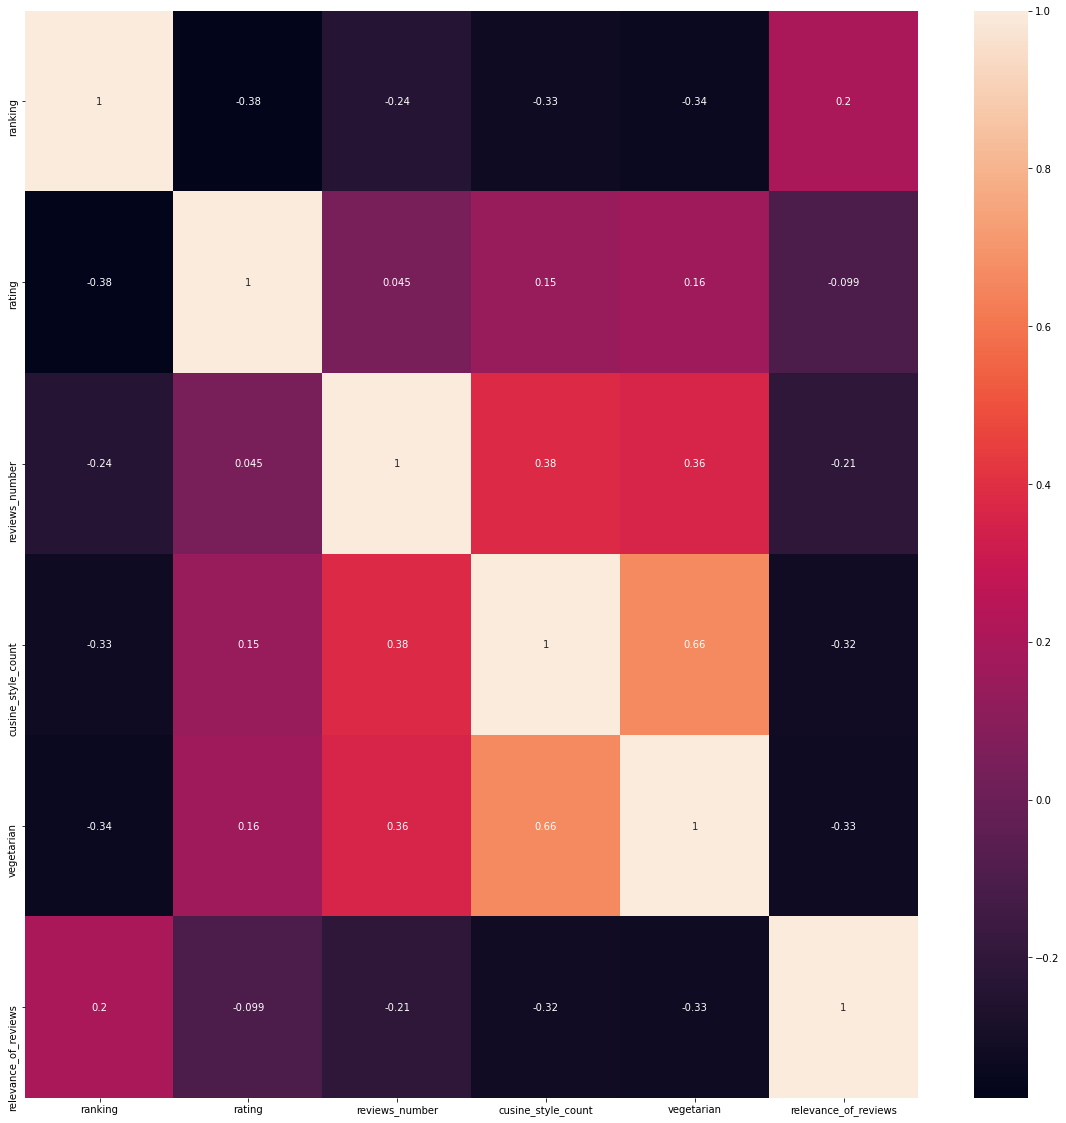

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(preparation1[numeric_columns].corr(),annot=True)
#Сильной корреляции нет


In [24]:
#Разделим данные по городам
cities = preparation1['city'].value_counts().reset_index()['index']
preparation1 = pd.get_dummies(preparation1,columns=['city'],dummy_na=True)
for city in cities:
    # preparation1[city] = preparation1['city'].apply(lambda x: float(city == x))
    numeric_columns.append('city_'+city)


In [25]:
#Оставляем только числовые столбцы
result = preparation1[numeric_columns]


In [26]:
#3.Заполняем пропуски

result['reviews_number'].fillna(0,inplace=True)


F:\projects\skillfactory_rds\envs\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [27]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = result.drop(['rating'], axis = 1)
y = result['rating']

In [28]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [29]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [30]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [31]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))


MAE: 0.19088171655247022
